In [ ]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 6.4 MB 40.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In this notebook we will perform time series forecasting (Univariate time series analysis) using various different deep learning sequential models. 


# Importing the Libraries

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN, GRU, MaxPooling1D, Flatten, Bidirectional, Convolution1D, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import datetime
from keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')
tf.random.set_seed(1234)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the dataset

In this notebook, we are using 5 years of historical stock prices of the AAPL.

In [ ]:
tsla = yf.Ticker('AAPL')

# get historical data as stock
stock = tsla.history(period="5y")

# # Save dataframe as CSV file
# stock.to_csv('AAPL.csv')

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-01,34.249398,34.745079,34.216352,34.598736,134411600,0.0,0.0
2017-05-02,34.825330,34.955152,34.660102,34.818249,181408800,0.0,0.0
2017-05-03,34.365061,34.813539,34.053490,34.712040,182788000,0.0,0.0
2017-05-04,34.584574,34.730918,34.416984,34.586933,93487600,0.0,0.0
2017-05-05,34.641224,35.165233,34.641224,35.160515,109310800,0.0,0.0


In [ ]:
stock.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-25,161.119995,163.169998,158.460007,162.880005,96046400,0.0,0.0
2022-04-26,162.250000,162.339996,156.720001,156.800003,95623200,0.0,0.0
2022-04-27,155.910004,159.789993,155.380005,156.570007,88063200,0.0,0.0
2022-04-28,159.250000,164.520004,158.929993,163.639999,130216800,0.0,0.0
2022-04-29,161.839996,166.199997,157.250000,157.649994,131587100,0.0,0.0


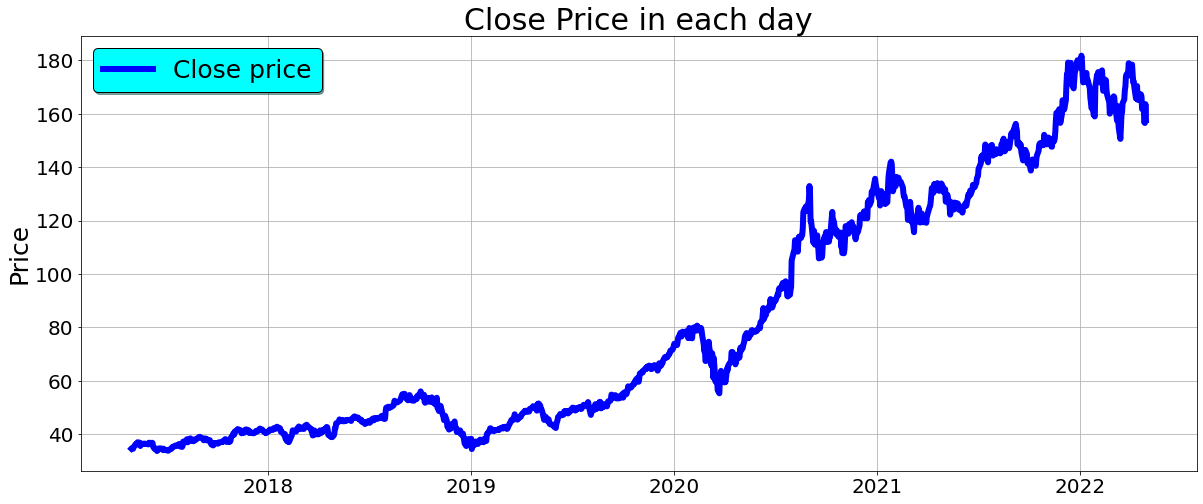

In [ ]:

# Visualizing the price on each day
plt.figure(figsize = (20,8))
plt.grid(b=True, which='major', axis='both')
plt.title('Close Price in each day', fontsize = 30)
plt.plot(stock.index, stock['Close'], color='blue', label='Close price', linewidth=6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Price', fontsize = 25)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

In [ ]:
# The target value to be predicted is going to be the “Close” stock price value. 
stock = stock[['Close']] 


## Splitting the data into train and test

We will use data from 2017 to 2020 in train dataset and keep 2021 as test dataset to evaluate our model performance. 


In [ ]:

stock_train = stock[stock.index < '2021'] # Store the data before 2021 in train data
stock_test = stock[stock.index > '2021'] # Store the data after 2021 in test data


In [ ]:
stock_train

,Close
Date,
2017-05-01,34.598736
2017-05-02,34.818249
2017-05-03,34.712040
2017-05-04,34.586933
2017-05-05,35.160515
...,...
2020-12-24,130.994537
2020-12-28,135.679626
2020-12-29,133.873077


In [ ]:
stock_test

,Close
Date,
2021-01-04,128.453430
2021-01-05,130.041611
2021-01-06,125.664207
2021-01-07,129.952286
2021-01-08,131.073929
...,...
2022-04-25,162.880005
2022-04-26,156.800003
2022-04-27,156.570007


## Normalizing the Data

Deep Learning models are very sensitive to the scale of the data. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. So, we will define a scaler to normalize the data. Here, we use MinMaxScalar to scale all the data to be in the region of 0 and 1.

In [ ]:

scaler = StandardScaler()
stock_train['Close'] = scaler.fit_transform(stock_train)
stock_test['Close'] = scaler.transform(stock_test)

In [ ]:
stock_train['Close']

Date
2017-05-01   -0.952764
2017-05-02   -0.944151
2017-05-03   -0.948319
2017-05-04   -0.953227
2017-05-05   -0.930722
                ...   
2020-12-24    2.829438
2020-12-28    3.013262
2020-12-29    2.942380
2020-12-30    2.897593
2020-12-31    2.857479
Name: Close, Length: 926, dtype: float64

In [ ]:
stock_test['Close']

Date
2021-01-04    2.729734
2021-01-05    2.792048
2021-01-06    2.620296
2021-01-07    2.788544
2021-01-08    2.832553
                ...   
2022-04-25    4.080501
2022-04-26    3.841945
2022-04-27    3.832921
2022-04-28    4.110320
2022-04-29    3.875296
Name: Close, Length: 334, dtype: float64

# Data Preprocessing

Now consider the time steps, if I want to predict the close price in a day that how previous data should be considered.

For example: 

Let's take the timestep value 10. Let’s split the data into X, Y. In the 0th iteration, the first 10 elements goes as your first record and stored in X and the 11th elements will be put up in the y as output of that 10 records. Next, in the 1th iteration, from 1 to 11 elements are stored as record in X and 12th element in y as output. These records are nothing but feature values or input that is used to train our model and the output will be target value that model will predict.

This process of creating features and target variable is also known as **Data Windowing**

| X | y |
| --- | --- |
| 67, 34, 23, 42, 23, 45, 69, 12, 34, 25 | **27** |
| 34, 23, 42, 23, 45, 69, 12, 34, 25, **27** | **31** |
| 23, 42, 23, 45, 69, 12, 34, 25, 27, **31** | **33** |
| 42, 23, 45, 69, 12, 34, 25, 27, 31, **33** | **29** | 
| 23, 45, 69, 12, 34, 25, 27, 31, 33, **29** | **32** |
| 45, 69, 12, 34, 25, 27, 31, 33, 29, **32** | **34** |
| 69, 12, 34, 25, 27, 31, 33, 29, 32, **34** | **28** |

In [ ]:
# Here we will use previous one 60 days as features and next day as output or target
# Preparing Train dataset


window_size = 60
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(window_size, len(stock_train)):
    X_train.append(stock_train.iloc[i-window_size:i].values) 
    y_train.append(stock_train.iloc[i, -1]) # consider Close as target
# Change them to numpy array
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)

In [ ]:
print('Orignial length of train data : ', len(stock_train))
print('length of train data after windowing : ', len(X_train))

Orignial length of train data :  926
length of train data after windowing :  866


In [ ]:
X_train.shape

(866, 60, 1)

In [ ]:
# Preparing Test dataset


# Concatenate train data to test data
dataset_total = np.concatenate((stock_train, stock_test), axis = 0)
# Split test data and last window-size of train data
inputs = dataset_total[len(dataset_total) - len(stock_test) - window_size:]
# Do the same thing for test data
X_test = []
y_test = []
for i in range(window_size, window_size+len(stock_test)):
    X_test.append(inputs[i-window_size:i, :]) 
    y_test.append(inputs[i, -1]) # consider Close as target
# Change them to numpy array
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

## Fitting deep learning models



## Gated Recurrent Unit (GRU)

GRU or Gated recurrent unit is an advancement of the standard RNN. To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, **update gate** and **reset gate**. Basically, these are the two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction. If carefully trained, GRU can perform extremely well even in complex scenarios.

**Architecture**

<img src = "https://miro.medium.com/max/700/1*S3lzZmcfwiMr8UcG2N4wEw.png">

As shown in the Figure above, a GRU unit is composed of:

- **Reset Gate -**The first gate is the reset gate. It determines how to combine the new input with the previous memory, deciding how much of the information from previous time steps can be forgotten.

- **Update Gate -**The second gate is the update gate. It helps the model to determine how much of the information from previous time steps needs to be passed along to the future. That is really powerful because the model can decide to copy all the information from the past and eliminate the risk of vanishing gradient problem. 

- **Memory -** It brings informations along the entire sequence and represents the memory of the network.



In [ ]:
model_1 = Sequential()
model_1.add(GRU(units=256, input_shape = (X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.5))
model_1.add(Dense(units=10))
model_1.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_1.compile(optimizer = adamopt, loss = 'mse')
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 5,
                          restore_best_weights = True)

model_1_history = model_1.fit(X_train, y_train, epochs = 100, callbacks = earlystop)


Epoch 1/100
30/30 [==============================] - 8s 198ms/step - loss: 0.0594
Epoch 2/100
30/30 [==============================] - 7s 249ms/step - loss: 0.0156
Epoch 3/100
30/30 [==============================] - 7s 240ms/step - loss: 0.0156
Epoch 4/100
30/30 [==============================] - 7s 236ms/step - loss: 0.0161
Epoch 5/100
30/30 [==============================] - 8s 254ms/step - loss: 0.0149
Epoch 6/100
30/30 [==============================] - 7s 230ms/step - loss: 0.0118
Epoch 7/100
30/30 [==============================] - 7s 228ms/step - loss: 0.0119
Epoch 8/100
30/30 [==============================] - 4s 133ms/step - loss: 0.0117
Epoch 9/100
30/30 [==============================] - 4s 132ms/step - loss: 0.0132
Epoch 10/100
30/30 [==============================] - 4s 131ms/step - loss: 0.0122
Epoch 11/100
30/30 [==============================] - 4s 132ms/step - loss: 0.0115
Epoch 12/100
30/30 [==============================] - 4s 132ms/step - loss: 0.0115
Epoch 13/100


RMSE : 0.0997251294808935


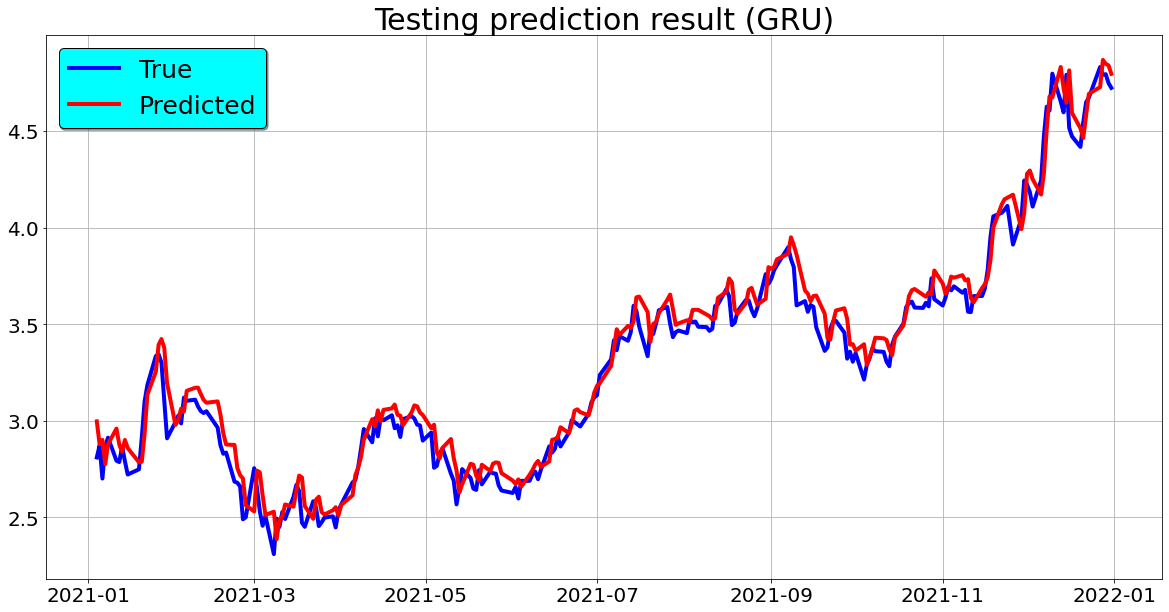

In [ ]:
test_predict_1 = model_1.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_1)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (GRU)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_1,linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

## SimpleRNN

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

Recurrent neural networks not only get the data from just previous layer data but also get some information from the previous layers in order to give output. RNNs are able to carry long term dependencies while taking care of short term changes.

-------------------------------

**Architecture :**

<img src = "https://miro.medium.com/max/700/1*jwv3NQpr5HresJ7ViSMVTA.png">

**Weights :** In RNNs, a weight matrix U connects the input vector at time t to the hidden layer neurons of time t, a weight matrix W connects the hidden layer neurons to the neurons of time t-1 and t+1, and a weight matrix V connects the hidden layer neurons to the output vector of time t; all the weight matrices are constant for each time step. 

**Input :** The network's output at time step t is represented by the vector x(t).

**Hidden state :** The hidden state at time t is represented by the vector h(t), which acts as a kind of network memory.

**Output  :** The vector y^(t) ​is the output of the network at time t.

### Learning algorithm

The learning process' purpose is to identify the best weight matrices U, V, and W that offer the best prediction of y(t) of the true value y starting with the input x(t) (t).
To do so, we design a loss function, abbreviated J, as an objective function that quantifies the difference between the real and predicted values across the whole training set. It is given by,

<img src = "https://miro.medium.com/max/419/1*BFwXWNso89iL59aEzrCUJA.png">

where,
- the cost function L evaluates the distances between the real and predicted values on a single time step;
- m is the size of the training set;
- θ the vector of model parameters.

The loss function J is minimised by performing two primary steps: forward and backward propagation across time. These stages are repeated numerous times, and the epoch number is the total number of iterations.

In [ ]:
model_2 = Sequential()
model_2.add(SimpleRNN(units=128, input_shape = (X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=10))
model_2.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_2.compile(optimizer = adamopt, loss = 'mse')
model_2_history = model_2.fit(X_train, y_train, epochs = 100, batch_size = 100, callbacks = earlystop)

Epoch 1/100
10/10 [==============================] - 1s 29ms/step - loss: 0.2762
Epoch 2/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0521
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0351
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0261
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0208
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0196
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0169
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0150
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0145
Epoch 10/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0119
Epoch 11/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0122
Epoch 12/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0117
Epoch 13/100
10/10 [=====

RMSE : 0.16394736158532042


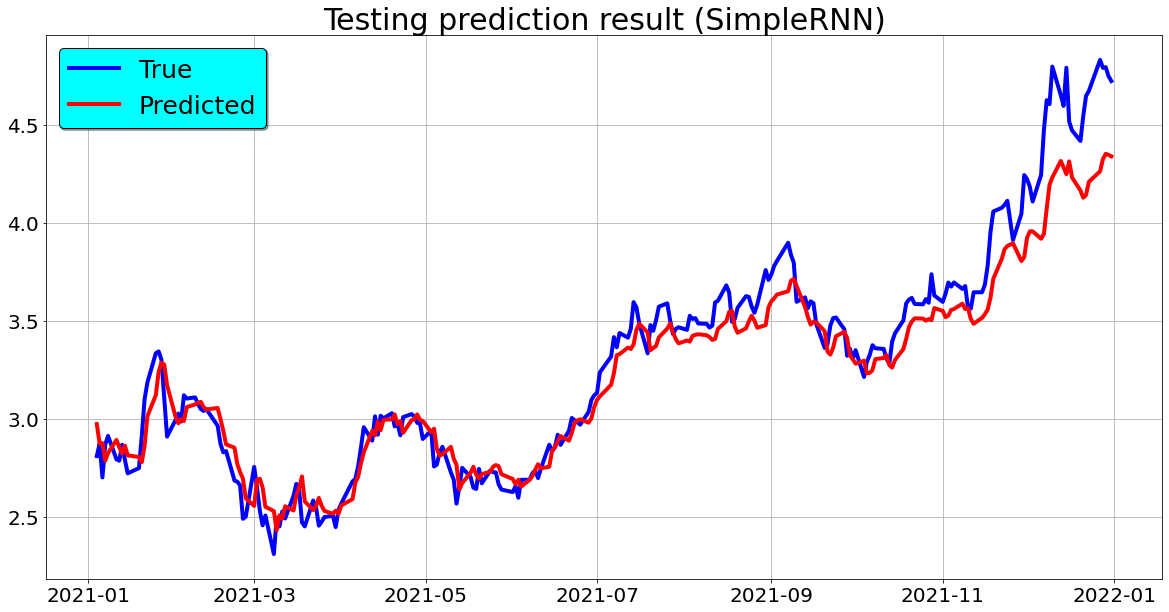

In [ ]:

test_predict_2 = model_2.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_2)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (SimpleRNN)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_2, linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

## Long Short Term Memory(LSTM)

Long Short Term Memory(LSTM) is a special type of Recurrent Neural Network(RNN) which can retain important information over time using memory cells.

This property of LSTMs makes it a wonderful algorithm to learn sequences that are interdependent and can help to build solutions like language translation, sales time series, chatbots, autocorrections, next word suggestions, etc.

**Architecture**

<img src = "https://miro.medium.com/max/700/1*NxwjL6svSZe8Eo-GyCxh3w.png">

- **Forget Gate -** The first gate is the forget gate. This gate determines whether or not information should be preserved or destroyed. The sigmoid function passes the information from the previous hidden state as well as the information from the current input. If the output is close to 0, the information can be discarded, however if the output is close to 1, the information must be kept.

- **Input Gate -** The input gate is the second gate. This is used to update the status of the cell. Initially, a sigmoid function is given the prior hidden state and the current input as inputs (the closer the output is to 1, the more important the information). In order to optimise network tuning, it additionally feeds the hidden state and current input through a tanh function to compress values between -1 and 1.

- **Cell State -** The cell state may be computed once the input gate has been activated. First, the previous time step's cell state is element-wise multiplied by the forget gate's output. When values in the cell state are multiplied by values near to 0, this allows values in the cell state to be ignored. The input gate's output is then added to the cell state element by element. The new cell state is the output.

- **Output Gate -** The third and final gate is the output gate, that decides the value of the next hidden state, which contains information about previous inputs. First, the previous hidden state and current input are summed and passed to a sigmoid function. Then the new cell state is passed to the tanh function. At the end the tanh output with the sigmoid output are multiplied to decide what information the hidden state should contain. The output is the new hidden state. The new cell state and the new hidden state are then carried over to the next time step.


Lets see how LSTMs can be used to learn the patterns in the stock prices. Using this template you will be able to predict tomorrow’s price of a stock based on the last 30 days prices.



In [ ]:
model_3 = Sequential()
model_3.add(LSTM(units=256, input_shape = (X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))
model_3.add(Dense(units=10))
model_3.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_3.compile(optimizer = adamopt, loss = 'mse')
model_3_history = model_3.fit(X_train, y_train, epochs = 100, batch_size = 100,callbacks = earlystop)

Epoch 1/100
10/10 [==============================] - 5s 313ms/step - loss: 0.2238
Epoch 2/100
10/10 [==============================] - 3s 311ms/step - loss: 0.0305
Epoch 3/100
10/10 [==============================] - 3s 311ms/step - loss: 0.0136
Epoch 4/100
10/10 [==============================] - 3s 313ms/step - loss: 0.0107
Epoch 5/100
10/10 [==============================] - 3s 312ms/step - loss: 0.0101
Epoch 6/100
10/10 [==============================] - 3s 312ms/step - loss: 0.0106
Epoch 7/100
10/10 [==============================] - 3s 313ms/step - loss: 0.0095
Epoch 8/100
10/10 [==============================] - 3s 311ms/step - loss: 0.0101
Epoch 9/100
10/10 [==============================] - 3s 311ms/step - loss: 0.0100
Epoch 10/100
10/10 [==============================] - 3s 309ms/step - loss: 0.0095
Epoch 11/100
10/10 [==============================] - 3s 311ms/step - loss: 0.0091
Epoch 12/100
10/10 [==============================] - 3s 310ms/step - loss: 0.0100
Epoch 13/100


RMSE : 0.15977460756459486


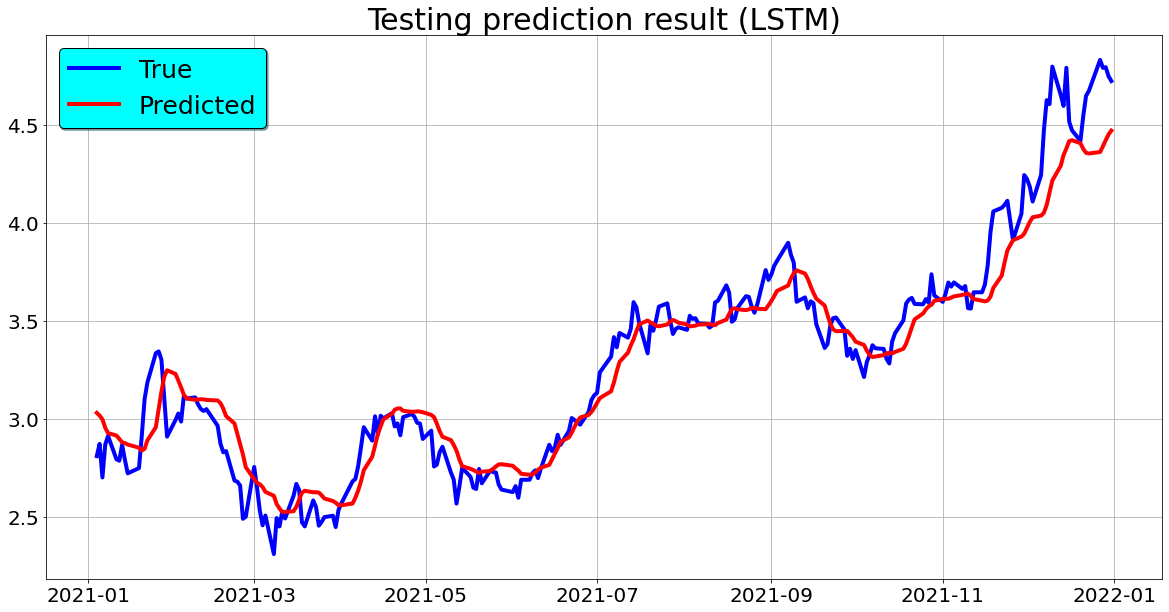

In [ ]:
test_predict_3=model_3.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_3)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (LSTM)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_3, linewidth = 4, color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

## Bidirectional LSTM

On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.

In [ ]:
model_4 = Sequential()
model_4.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_train[1,:].shape))))
model_4.add(Dropout(0.2))
model_4.add(Dense(1))
adamopt = Adam(lr=0.001)
model_4.compile(optimizer = adamopt, loss = 'mse')
model_4.fit(X_train, y_train, epochs = 100, batch_size = 100,callbacks = earlystop)

Epoch 1/100
10/10 [==============================] - 5s 223ms/step - loss: 0.5351
Epoch 2/100
10/10 [==============================] - 2s 223ms/step - loss: 0.0916
Epoch 3/100
10/10 [==============================] - 4s 368ms/step - loss: 0.0561
Epoch 4/100
10/10 [==============================] - 3s 264ms/step - loss: 0.0392
Epoch 5/100
10/10 [==============================] - 2s 220ms/step - loss: 0.0316
Epoch 6/100
10/10 [==============================] - 2s 220ms/step - loss: 0.0300
Epoch 7/100
10/10 [==============================] - 2s 223ms/step - loss: 0.0275
Epoch 8/100
10/10 [==============================] - 2s 222ms/step - loss: 0.0277
Epoch 9/100
10/10 [==============================] - 2s 221ms/step - loss: 0.0239
Epoch 10/100
10/10 [==============================] - 2s 222ms/step - loss: 0.0209
Epoch 11/100
10/10 [==============================] - 2s 219ms/step - loss: 0.0236
Epoch 12/100
10/10 [==============================] - 2s 223ms/step - loss: 0.0202
Epoch 13/100


RMSE : 0.30226545249844455


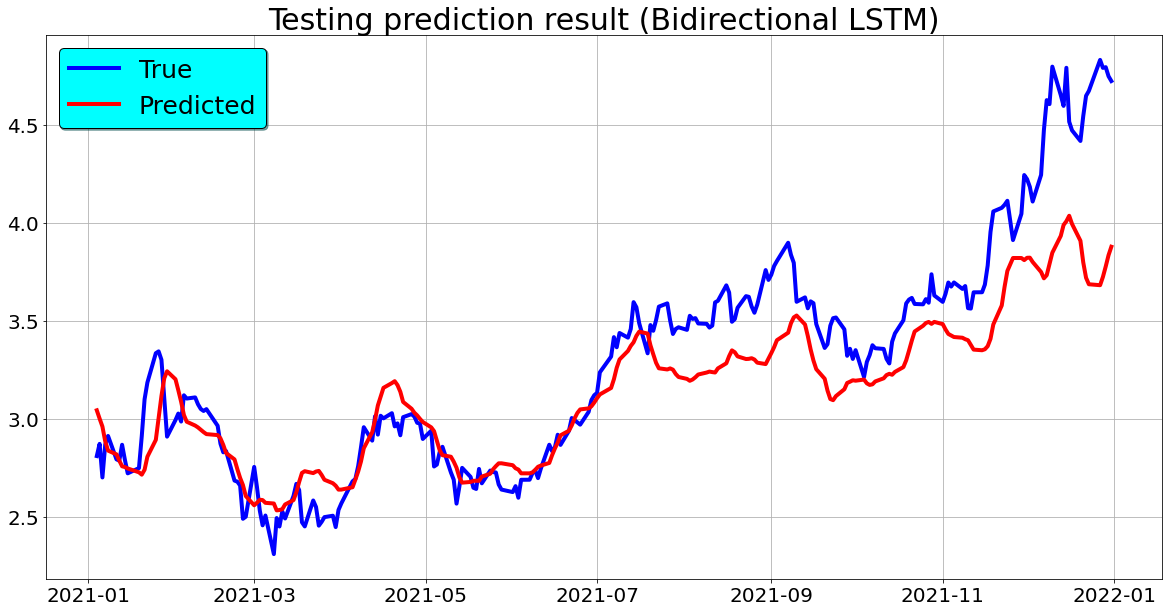

In [ ]:
test_predict_4 = model_4.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_4)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (Bidirectional LSTM)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_4, linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

## CNN-LSTM Encoder-Decoder 



A convolutional neural network, or CNN, can be used as the encoder in an encoder-decoder architecture.

- the **encoder**, that is responsible for stepping through the input time steps and encoding the entire sequence into a fixed length vector called a context vector;

- the **decoder**, that is responsible for stepping through the output time steps while reading from the context vector.

A 1D CNN is capable of reading across sequence input and automatically learning the prominent features, rather than directly supporting sequence input. These can then be decoded using an LSTM decoder as usual. CNN-LSTM models are hybrid models that combine a CNN and an LSTM, and we're putting them together in this case in an encoder-decoder architecture.

For the encoder, we'll define a simple yet effective CNN architecture consisting of two convolutional layers followed by a max pooling layer, with the results flattened.

The input sequence is read by the first convolutional layer, which projects the results onto feature maps. The second layer repeats the first layer's operation on the feature maps, seeking to magnify any notable features. We'll read the input sequences with a kernel size of three time steps and use 64 feature mappings per convolutional layer.

By preserving 1/4 of the values with the largest (max) signal, the max pooling layer simplifies the feature maps. After the pooling layer, the distilled feature maps are flattened into a single long vector that can be utilised as input to the decoding process.

In [ ]:
model_5 = Sequential()
model_5.add(Convolution1D(filters=256, kernel_size=3, activation='relu', input_shape=(X_train[1,:].shape)))
model_5.add(Convolution1D(filters=256, kernel_size=3, activation='relu'))
model_5.add(MaxPooling1D(pool_size=2))
model_5.add(Flatten())
model_5.add(RepeatVector(y_train.shape[1]))
model_5.add(LSTM(128, activation='relu', return_sequences=True))
model_5.add(TimeDistributed(Dense(100, activation='relu')))
model_5.add(TimeDistributed(Dense(1)))
model_5.compile(loss='mse', optimizer='adam')
model_5.fit(X_train, y_train, epochs = 100, batch_size = 100,callbacks = earlystop)

Epoch 1/100
10/10 [==============================] - 4s 236ms/step - loss: 0.5582
Epoch 2/100
10/10 [==============================] - 2s 233ms/step - loss: 0.1925
Epoch 3/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0722
Epoch 4/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0496
Epoch 5/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0432
Epoch 6/100
10/10 [==============================] - 2s 231ms/step - loss: 0.0359
Epoch 7/100
10/10 [==============================] - 2s 235ms/step - loss: 0.0293
Epoch 8/100
10/10 [==============================] - 2s 232ms/step - loss: 0.0253
Epoch 9/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0237
Epoch 10/100
10/10 [==============================] - 2s 234ms/step - loss: 0.0187
Epoch 11/100
10/10 [==============================] - 2s 233ms/step - loss: 0.0176
Epoch 12/100
10/10 [==============================] - 2s 230ms/step - loss: 0.0156
Epoch 13/100


RMSE : 0.30961888536515686


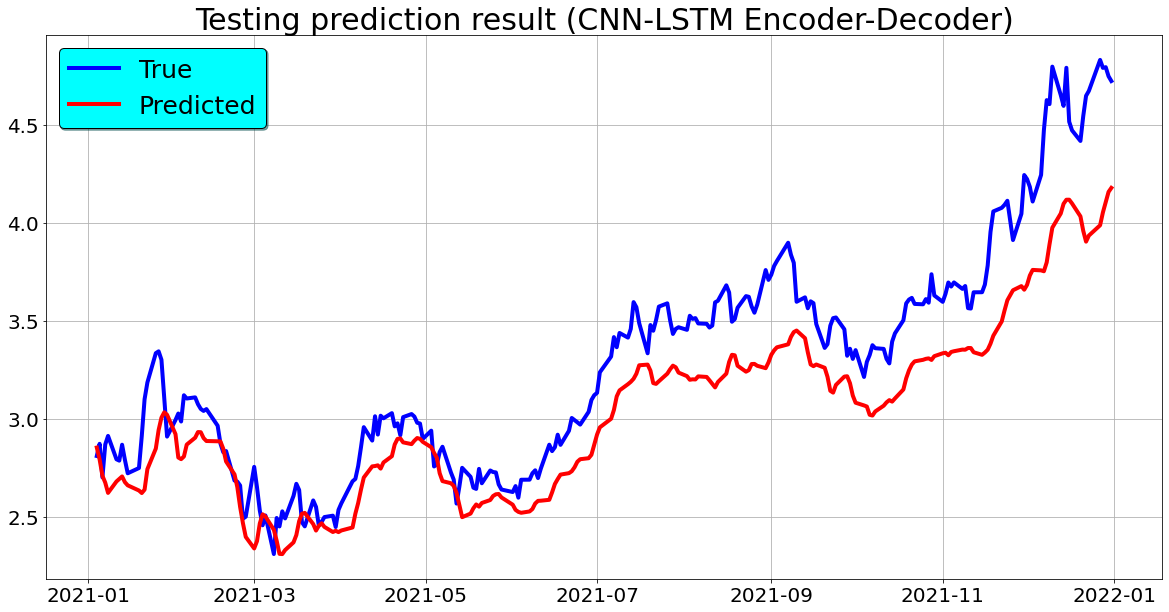

In [ ]:
test_predict_5 = model_5.predict(X_test)
test_predict_5 = test_predict_5.reshape(-1,1)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_5)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (CNN-LSTM Encoder-Decoder)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_5 ,linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

## Convolutional Neural Network

Although traditionally developed for two-dimensional image data, CNNs can be used for 1D data. This allows CNN to be used in more general data type including texts and other time series data. Instead of extracting spatial information, you use 1D convolutions to extract information along the time dimension.

**Conv1D: Convolving on time dimension**
<img src = "https://www.macnica.co.jp/business/ai_iot/columns/image5_2.png">

A one-dimensional CNN is a CNN with a convolutional hidden layer that operates on a one-dimensional sequence. In some circumstances, such as with very lengthy input sequences, a second convolutional layer may be used, and then a pooling layer is used to reduce the output of the convolutional layer to the most important bits.

A dense fully connected layer follows the convolutional and pooling layers, which interprets the features extracted by the convolutional part of the model. Between the convolutional layers and the dense layer, a flatten layer is employed to compress the feature mappings to a single one-dimensional vector.

In [ ]:
model_6 = Sequential()
model_6.add(Convolution1D(256, kernel_size=3, activation='relu', input_shape=(X_train[1,:].shape)))
model_6.add(Convolution1D(128, kernel_size=3, activation='relu'))
model_6.add(MaxPooling1D(pool_size=2))
model_6.add(Flatten())
model_6.add(Dense(1))
model_6.compile(loss='mse', optimizer='adam')
model_6_history = model_6.fit(X_train, y_train, epochs = 100, batch_size = 100)

Epoch 1/100
10/10 [==============================] - 2s 108ms/step - loss: 0.2529
Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0590
Epoch 3/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0366
Epoch 4/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0260
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0218
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0220
Epoch 7/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0192
Epoch 8/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0179
Epoch 9/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0158
Epoch 10/100
10/10 [==============================] - 1s 108ms/step - loss: 0.0152
Epoch 11/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0136
Epoch 12/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0149
Epoch 13/100


RMSE : 0.11747089479934027


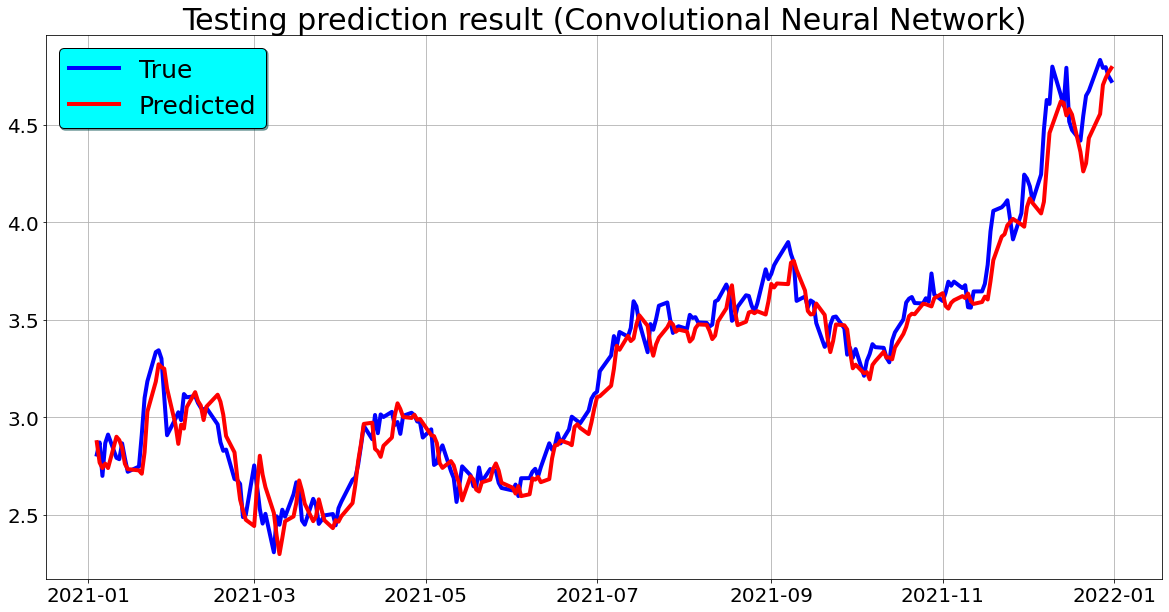

In [ ]:
test_predict_6 = model_6.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_6)))

plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result (Convolutional Neural Network)', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict_6, linewidth = 4, color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

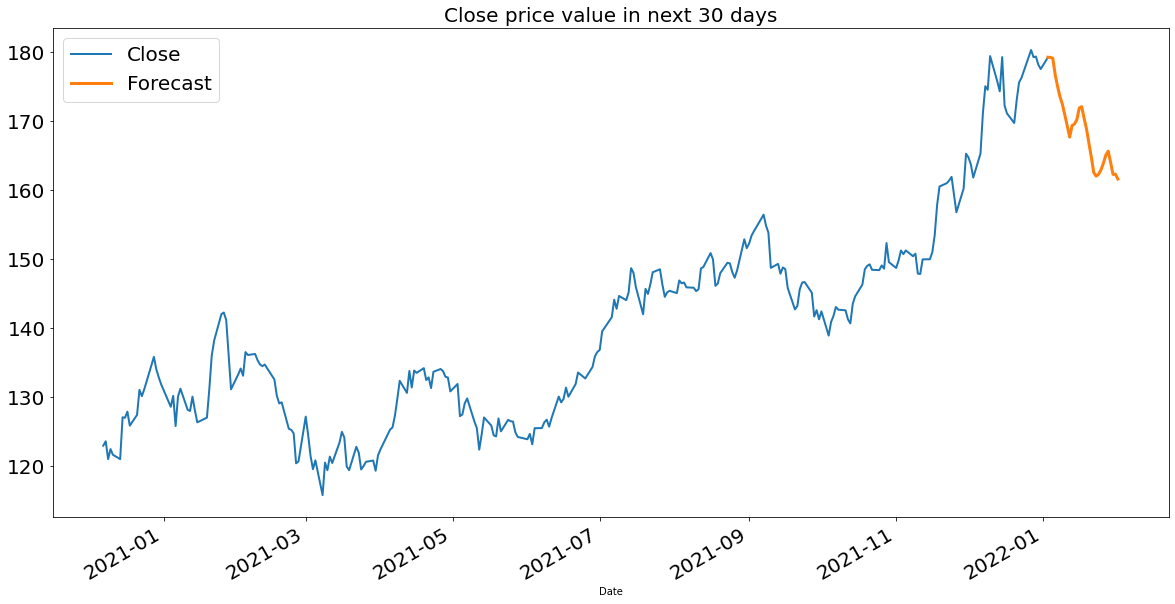

In [ ]:
x_input=X_test[-1:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps = 60
i=0
forecast = []
while(i<30):
    
    if(len(temp_input)>60):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        
        x_input = x_input.reshape((1, n_steps, 1))
        forecast.append(x_input)
        yhat = model_6.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        forecast.append(x_input)
        yhat = model_6.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    
df3=scaler.inverse_transform(lst_output)
df1=scaler.inverse_transform(stock_test).tolist()
df1.extend(df3)
today = datetime.datetime.now().strftime('%m/%d/%Y')
forecast_dates=pd.date_range(start=today, periods=30)
forecast=pd.DataFrame(forecast_dates,columns=['Date'])
forecast['Date']=pd.to_datetime(forecast['Date'])
forecast.sort_values('Date',inplace=True)
forecast['Close']=df3
forecast.set_index('Date',inplace=True)
result_df=pd.concat([stock,forecast])
ax = result_df[-300:-29].plot(figsize=(20,10),linewidth=2,fontsize=20,grid=True)
result_df[-30:].plot(ax=ax,linewidth=3)
plt.title('Close price value in next 30 days', fontsize = 20)
plt.legend(['Close','Forecast'],fontsize=20)

In [5]:
import pandas as pd
xls = pd.ExcelFile('practise_purpose.xlsx')

df1 = pd.read_excel(xls, 'P1')
df2 = pd.read_excel(xls, 'P2')
df3 = pd.read_excel(xls, 'P3')  